# Use OpenAI Embeddings to Find Closest Word 
###  Given two words we can "guess" the third word 
####            [{1:"king",2:"woman",3:"queen"},
####             {1:"Paris",2:"England",3:"London"},
####             {1:"Spain",2:"Tokyo",3:"Japan"},
####             {1:"Apple",2:"phone",3:"iPhone"},
####             {1:"fish",2:"home",3:"aquarium"},
####             {1:"read",2:"pleasure",3:"book"},
####            {1:"computer",2:"network",3:"internet"}]

In [4]:
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
import json
import os

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

openai.api_key = os.getenv("OPENAI_API_KEY")

In [6]:
word_triples = [{1:"king",2:"woman",3:"queen"},
              {1:"Paris",2:"England",3:"London"},
              {1:"Spain",2:"Tokyo",3:"Japan"},
              {1:"Apple",2:"phone",3:"iPhone"},
              {1:"fish",2:"chips",3:"meal"},
              {1:"read",2:"pleasure",3:"book"},
              {1:"walk",2:"exercise",3:"run"},
              {1:"computer",2:"network",3:"internet"}
              ]

In [7]:
# get list of all words
words = []
for row in word_triples:
    words.append(row[1])
    words.append(row[2])
    words.append(row[3])
print(words)


    

['king', 'woman', 'queen', 'Paris', 'England', 'London', 'Spain', 'Tokyo', 'Japan', 'Apple', 'phone', 'iPhone', 'fish', 'chips', 'meal', 'read', 'pleasure', 'book', 'walk', 'exercise', 'run', 'computer', 'network', 'internet']


In [8]:
def getEmbedding(word):
    response = openai.embeddings.create(
    input=word,
    model="text-embedding-ada-002"
    )
    return response.data[0].embedding

In [9]:
# get embeddings for all words
embeddings = {}
for word in words:
    embeddings[word] = np.array(getEmbedding(word))

# normalize embeddings
for word in words:
    embeddings[word] = embeddings[word]/np.linalg.norm(embeddings[word])
    
import csv

# Specify the file path
file_path = "embedFirstDocument.csv"

# Write the word and embedding to the CSV file
with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Word', 'Embedding'])  # Write the header
    for word, embedding in embeddings.items():
        writer.writerow([word, embedding.tolist()])

In [10]:
import numpy as np

def find_nearest_word_to_sum(word1,word2):
    # Calculate cosine similarity between the input embedding and all embeddings 
   # get the sum of the two embeddings vectors np.array
    esum = embeddings[word1] + embeddings[word2]
    esum = esum/np.linalg.norm(esum)
    # find the nearest word not in the input
    similarities = {}
    for word in words:
        if word != word1 and word != word2:
            similarities[word] = np.dot(esum, embeddings[word])
    nearest_word = max(similarities, key=similarities.get)
    return nearest_word


In [11]:
# loop over the word triples and find the nearest word to the sum of the first and second word
for row in word_triples:
    word1 = row[1]
    word2 = row[2]
    word3 = row[3]
    nearest_word = find_nearest_word_to_sum(word1,word2)
    print("The nearest word to", word1, "+", word2, "is", nearest_word, "and the actual word is", word3)

The nearest word to king + woman is queen and the actual word is queen
The nearest word to Paris + England is London and the actual word is London
The nearest word to Spain + Tokyo is Japan and the actual word is Japan
The nearest word to Apple + phone is iPhone and the actual word is iPhone
The nearest word to fish + chips is meal and the actual word is meal
The nearest word to read + pleasure is meal and the actual word is book
The nearest word to walk + exercise is run and the actual word is run
The nearest word to computer + network is internet and the actual word is internet


In [12]:
# add first two embeddings and divide by 2 in each row
# add each prection vecctor to matrix of predictions
matrix = np.array([])
i = 1
for row in word_triples:
    r = (embeddings[row[1]] + embeddings[row[2]]) / 2
    # add this vector as a row to matrix_of_predictions
    if i == 1:
        matrix = r
    else:
        matrix = np.vstack((matrix, r))
    i += 1
for row in word_triples:
    matrix = np.vstack((matrix, embeddings[row[3]]))
print(matrix.shape)
# reshape predictions



(16, 1536)


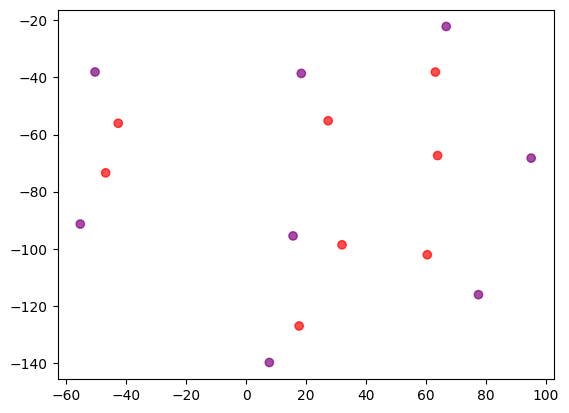

In [15]:
from sklearn.manifold import TSNE
import matplotlib
from ast import literal_eval
import numpy as np
from ast import literal_eval
tsne = TSNE(n_components=2, perplexity=5, random_state=3)

X_2d = tsne.fit_transform(matrix)
colors = ["red", "darkorange",  "blue", "darkgreen","purple"]
# get back original dataframe with columns and loan_status
x = [x for x,y in X_2d]
y = [y for x,y in X_2d]
color_indices = [0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1]
colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.7)
plt.show()


In [17]:
# using openai to tokenize the text
import tiktoken
text = "The quick brown fox jumped over the lazy dog." 

encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
tokens = encoding.encode(text)
print(tokens)
text_new = encoding.decode(tokens)
print(text_new)

[791, 4062, 14198, 39935, 27096, 927, 279, 16053, 5679, 13]
The quick brown fox jumped over the lazy dog.
